# ASSIGNMENT 1: CARS DATASET

## Eralda Gjika

Dataset
 The Cars Dataset can be found here: (https://ai.stanford.edu/~jkrause/cars/car_dataset.html) 
 The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. 
Objective 
 Your clients would like a model that can classify cars found from images taken from traffic cameras. 
  This assignment will involve exploring the importance of the size of a labelled dataset for supervised learning. 
Note: For questions where you are asked to explain or interpret results, please do so within the Jupyter 
notebook (or equivalent) using Markdown 


# Import Dependencies

In [60]:
import numpy as np
from typing import List
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import transforms as T
from tqdm import tqdm
import gzip
import tarfile
from scipy.io import loadmat
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

## Set seeds for reproducibility

In [2]:
SEED = 12345
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Extract the data from .tar files

In [3]:
my_tar = tarfile.open('./cars_train.tar')
my_tar.extractall('.') # specify which folder to extract to
my_tar.close()

# my_tar = tarfile.open('./car_devkit.tar')
# my_tar.extractall('.') # specify which folder to extract to
# my_tar.close()

my_tar = tarfile.open('./cars_test.tar')
my_tar.extractall('.') # specify which folder to extract to
my_tar.close()

In [4]:
train_annots = loadmat("./devkit/cars_train_annos.mat")['annotations']
train_classes = train_annots['class'][0]
train_fnames = train_annots['fname'][0]
train_label_dict = {filename.item(): cls.item() for filename, cls in zip(train_fnames, train_classes)}

# test_annots = loadmat("./devkit/cars_test_annos.mat")['annotations']
# test_fnames = test_annots['fname'][0]
# test_label_dict = [filename.item(): cls.item() for filename, cls in test_fnames]

In [ ]:
def remove_proportion_of_labels_for_each_class(dataset_labels: List[int],  proportion: float) -> None:
    n = len(dataset_labels)
    dataset_lbls_arr = np.array(dataset_labels)
    all_idxs = np.arange(n)
    for lbl in set(dataset_labels):
        # get all indices where we have the same class label: lbl 
        lbl_idxs = all_idxs[np.array(dataset_labels) == lbl]
        # randomly choose int(proportion*len(lbl_idxs) labels to be removed 
        idxs_to_be_dropped = list(np.random.choice(lbl_idxs, int(proportion*len(lbl_idxs)), replace=False))
    # set the index to -1 (-1 representing unlabelled data)
    for idx in idxs_to_be_dropped:
        dataset_lbls_arr[idx] = -1
    return dataset_labels, dataset_lbls_arr

### Task 1

In [113]:
def remove_proportion_of_labels_for_each_class(dataset_labels,  proportion):
    n = len(dataset_labels)
    dataset_lbls_arr = np.array(dataset_labels)
    all_idxs = np.arange(n)
    while True:
        again = False
        idxs_to_be_dropped = list(np.random.choice(all_idxs, int(proportion*n), replace=False))
        for lbl in set(dataset_labels):
            count = 0
            for idx in idxs_to_be_dropped:
                if dataset_labels[idx] == lbl:
                    count+=1 
            if count == len(dataset_lbls_arr[dataset_lbls_arr == lbl]):
                again = True
                break
        if not again:
            break
    for idx in idxs_to_be_dropped:
        dataset_lbls_arr[idx] = -1
    return dataset_labels, dataset_lbls_arr
        

## Task 2

In [109]:
img_to_be_deleted = []
for filename in train_label_dict:
    # load the image
    img = Image.open(f"./cars_train/{filename}")
    # check if it's not RGB
    if img.getbands() != ('R','G','B'):
        # append it to the list
        img_to_be_deleted.append(filename)

for filename in img_to_be_deleted:
    # remove the filename from the cars_train folder
    os.remove(f"./cars_train/{filename}")
    # remove 
    del train_label_dict[filename]
        

## Task 3

#### Load ResNet18 from PyTorch

In [110]:
model = resnet18(pretrained=True)
# replace the last resnet18 layer with Identity layer
model.fc = nn.Identity() # now, model output will be a vector of size 512

#### Iterate over each image to get the embedding

In [111]:
full_dataset = {}

img_transform = T.Compose([
                             T.Resize((224, 224)),
                             T.ToTensor(),
                             T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


for i, (k,v) in tqdm(enumerate(train_label_dict.items())):
    img = img_transform(Image.open(f"./cars_train/{k}")).unsqueeze(dim=0) # batch = 1
    embedding = model(img)
    full_dataset[i+1] = {"embedding": embedding.detach().numpy(), 
                         "class_idx": v,
                         "labelled": 1,
                        } 

8126it [03:28, 39.03it/s]


In [35]:
torch.save(full_dataset, "./full_dataset.pt")

## Task 4

In [145]:
full_dataset = torch.load("./full_dataset.pt")

In [146]:
original_labels, lbls_to_remove = remove_proportion_of_labels_for_each_class(
    [v['class_idx'] for _, v in full_dataset.items()], 
    0.6,
)
partial_dataset = full_dataset.copy()
for i,(k, v) in enumerate(partial_dataset.items()):
    if lbls_to_remove[i] == -1:
        v['labelled'] = 0

## Task 5

In [181]:
def split_dataset(dataset_inputs, dataset_labels, training_proportion):
    training_inputs, test_inputs, training_labels, test_labels = train_test_split(dataset_inputs, 
                                                                                  dataset_labels, 
                                                                                  train_size=training_proportion
                                                                                 )
    return np.array(training_inputs), np.array(training_labels), np.array(test_inputs), np.array(test_labels)

## Task 6

In [182]:
unlabelled_accuracies = []
dataset_inputs = [v['embedding'] for _, v in partial_dataset.items() if v['labelled']==1]
# subtract 1 since the labels start from 1
dataset_labels = [v['class_idx'] - 1 for _, v in partial_dataset.items() if v['labelled']==1]

unlabelled_inputs = [v['embedding'] for _, v in partial_dataset.items() if v['labelled']==0]
# subtract 1 since the labels start from 1
original_labels_for_unlabelled_data = [v['class_idx']-1 for _, v in partial_dataset.items() if v['labelled']==0]

for training_proportion in tqdm([0.5, 0.7, 0.9]):
    training_inputs, training_labels, _, _ = split_dataset(
        dataset_inputs,
        dataset_labels,
        training_proportion
    )
    classifier = SGDClassifier(loss='modified_huber', max_iter=1000, random_state=54321)
    classifier.fit(training_inputs[:,0,:], training_labels)
    
    preds = classifier.predict(np.array(unlabelled_inputs)[:,0,:])
    unlabelled_accuracies.append(np.mean(preds == np.array(original_labels_for_unlabelled_data)))


100%|██████████| 3/3 [00:48<00:00, 16.03s/it]


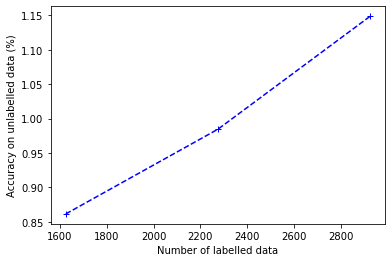

In [183]:
l = len(dataset_inputs)
plt.plot([int(0.5*l), int(0.7*l), int(0.9*l)], 
         [acc*100 for acc in unlabelled_accuracies], "b+--")
plt.xlabel("Number of labelled data")
plt.ylabel("Accuracy on unlabelled data (%)")
plt.show()

## Task 7

In [184]:
classifier = SGDClassifier(loss='modified_huber', max_iter=5000, random_state=12345)
classifier.fit(np.array(dataset_inputs)[:,0,:], np.array(dataset_labels))

probs = classifier.predict_proba(np.array(unlabelled_inputs)[:,0,:])

In [185]:
from scipy.stats import entropy

one_hot_labels = np.eye(196)[original_labels_for_unlabelled_data]
entropies = [entropy(one_hot_labels[i], probs[i]) for i in range(probs.shape[0])]

In [152]:
K = int(25* 100/60 * len(entropies))
indices_to_be_appended = np.argsort(entropies)[::-1][:K]

## Task 8:Final model training and evaluation

This final part is missing. The challenge was a great one with a lot of ideas on what libraries and functions to use. Combination of many statistical approaches and applications. 
Thank you a lot!
It was fun and made me learn more!

02 December 2022

Github account: https://github.com/EGjika 